In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib


In [43]:
data = pd.read_csv('data_processed.csv')

# Males/Females only to simplify the data
data = data[data.gender < 3]

data.shape

(13078, 125)

In [44]:
data['gender'] = np.where(data['gender'] == 1, 'male', 'female')

In [45]:
data.head()

,I can easily tell if someone else wants to enter a conversation.,I prefer animals to humans.,I try to keep up with the current trends and fashions.,"I find it difficult to explain to others things that I understand easily, when they don't understand it first time.",I dream most nights.,I really enjoy caring for other people.,I try to solve my own problems rather than discussing them with others.,I find it hard to know what to do in a social situation.,I am at my best first thing in the morning.,People often tell me that I went too far in driving my point home in a discussion.,...,I do not read legal documents very carefully.,I am not interested in understanding how wireless communication works.,I am curious about life on other planets.,"When I travel, I like to learn specific details about the culture of the place I am visiting.",I do not care to know the names of the plants I see.,EQ,SQ,accuracy,gender,age
0,3,1,3,2,4,3,1,3,1,3,...,2,1,4,4,3,37,49,80,male,39
1,4,3,3,2,2,2,2,3,4,4,...,4,4,3,4,2,54,14,98,female,21
2,3,3,3,1,1,2,2,2,3,1,...,3,4,3,2,4,57,12,95,female,32
3,2,2,2,1,2,1,3,2,4,4,...,2,3,3,4,1,43,32,80,female,53
4,3,1,2,4,4,2,3,3,2,3,...,2,1,3,4,1,26,57,97,male,17


In [46]:
df_gender = data.drop(['accuracy', 'age', 'EQ', 'SQ'], axis=1).groupby('gender').mean().T

In [47]:
df_gender['difference'] = (df_gender['male'] - df_gender['female'])/df_gender['male']

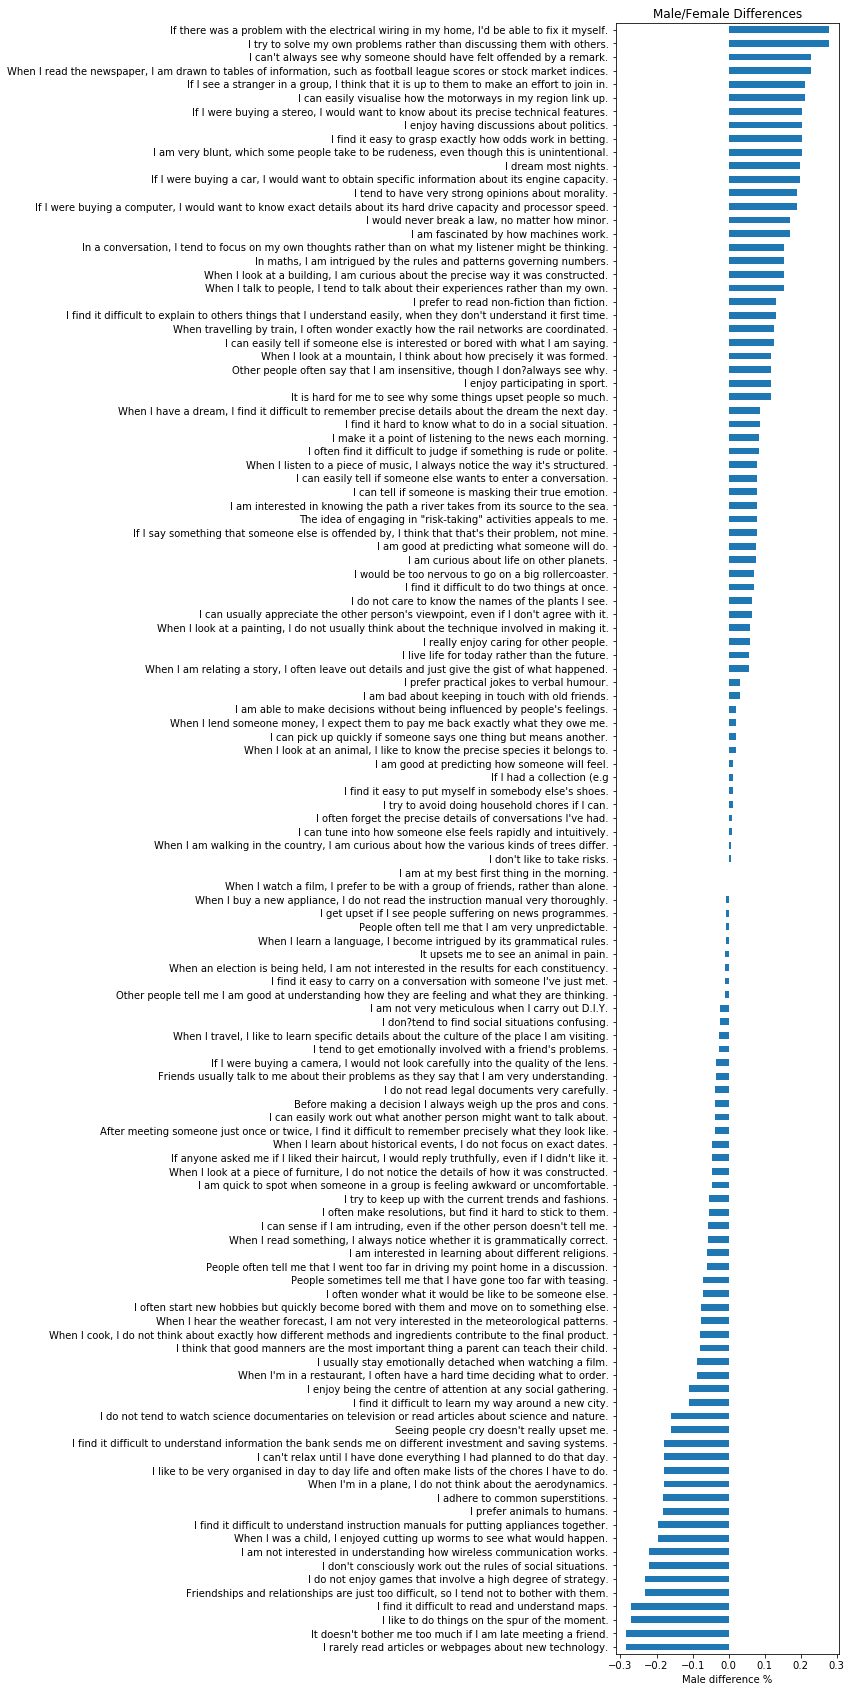

In [49]:
df_gender['difference'].sort_values().plot.barh(figsize=(4,30))
plt.title('Male/Female Differences')
plt.xlabel('Male difference %')